In [26]:
import os
import threading
import itertools
import random
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

def generate_pairs(n, k):
    if k > n*(n+1)//2:
        print("k cannot be greater than n*(n+1)/2. Setting k to n*(n+1)/2.")
        k = n*(n+1)//2

    pairs = set()
    while len(pairs) < k:
        x, y = sorted([random.randint(1, n), random.randint(1, n)])
        pairs.add((x, y))

    return list(pairs)
def getSubDir(directory):
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return subdirectories
def getImageFiles(directory):
    imageFiles = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):
                imageFiles.append(os.path.join(root, file))
    return imageFiles

def compareContours(image1,image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    _, thresh1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)

    # 寻找轮廓
    contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours1 or not contours2:
        return None
    img1c = np.zeros_like(image1)
    img2c = np.zeros_like(image2)
    cv2.drawContours(img1c, contours1, -1, (0,255,0), 3)
    cv2.drawContours(img2c, contours2, -1, (0,255,0), 3)

    # 使用matchShapes函数比较轮廓
    imgCorrel = calculate_correlation(cv2.cvtColor(img1c, cv2.COLOR_BGR2GRAY),cv2.cvtColor(img2c, cv2.COLOR_BGR2GRAY))

    return imgCorrel

def veifyContours(image1,image2):

    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    _, thresh1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)



    # 寻找轮廓
    contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours1))
    print(len(contours2))
    contour1 = contours1[0]
    contour2 = contours2[0]

    if not contours1 or not contours2:
        return None
    if len(contours1)!=1 or len(contours2)!=1:
        return None
    img1c = np.zeros_like(image1)
    img2c = np.zeros_like(image2)
    # 使用matchShapes函数比较轮廓
    similarity = cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0)
    cv2.drawContours(img1c, contours1, -1, (0,255,0), 3)
    cv2.drawContours(img2c, contours2, -1, (0,255,0), 3)
    correlation = calculate_correlation(cv2.cvtColor(img1c, cv2.COLOR_BGR2GRAY),cv2.cvtColor(img2c, cv2.COLOR_BGR2GRAY))

    return thresh1,thresh2,cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB),cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB),similarity,correlation

def calculate_correlation(image1, image2):
    # 将图像转换为浮点数并归一化
    image1_norm = image1.astype(np.float32) / 255.0
    image2_norm = image2.astype(np.float32) / 255.0

    # 计算图像的平均值和标准差
    mean1, std_dev1 = cv2.meanStdDev(image1_norm)
    mean2, std_dev2 = cv2.meanStdDev(image2_norm)

    # 检查除数是否为零或接近零
    eps = 1e-8
    if std_dev1 * std_dev2 < eps:
        return None
    else:
        covariance = cv2.mean((image1_norm - mean1) * (image2_norm - mean2))[0]
        correlation_coefficient = covariance / (std_dev1 * std_dev2)
    return abs(correlation_coefficient.item())




In [27]:
rootDir = "../ShapeNetCore_Depth"
dirs = getSubDir(rootDir)
print(dirs)

['02691156', '02747177', '02773838', '02801938', '02808440', '02818832', '02828884', '02843684', '02871439', '02876657', '02880940', '02924116', '02933112', '02942699', '02946921', '02954340', '02958343', '02992529', '03001627', '03046257', '03085013', '03207941', '03211117', '03261776', '03325088', '03337140', '03467517', '03513137', '03593526', '03624134', '03636649', '03642806', '03691459', '03710193', '03759954', '03761084', '03790512', '03797390', '03928116', '03938244', '03948459', '03991062', '04004475', '04074963', '04090263', '04099429', '04225987', '04256520', '04330267', '04379243', '04401088', '04460130', '04468005', '04530566', '04554684']


In [ ]:
for subDir in dirs:
    imageFiles = getImageFiles(rootDir+"/"+subDir)
    size = len(imageFiles)
    sample = 2500
    contours = []
    correlations = []
    print("filecounter:"+str(len(imageFiles)))
    imageidxlist = generate_pairs(size-1,sample)
    imageDic = {}
    for pair in imageidxlist:
        x,y = pair
        if x not in imageDic:
            ximg = cv2.imread(imageFiles[x])
            imageDic[x]=ximg
        if y not in imageDic:
            yimg = cv2.imread(imageFiles[y])
            imageDic[y]=yimg
    print(len(imageDic))
    for pair in tqdm(imageidxlist):
        idx1,idx2 = pair[0],pair[1]
        c1 = compareContours(imageDic[idx1],imageDic[idx2])
        c2 = calculate_correlation(cv2.cvtColor(imageDic[idx1], cv2.COLOR_BGR2GRAY),cv2.cvtColor(imageDic[idx2], cv2.COLOR_BGR2GRAY))
        if c1 is not None and c2 is not None:
            contours.append(c1)
            correlations.append(c2)
    print(len(correlations))
    print(len(contours))
    x = np.asarray(contours)
    y = np.asarray(correlations)
    plt.figure()
    plt.hist2d(x, y, bins=100,cmin = 1)
    plt.xlabel('contours pearson correlation coefficient')
    plt.ylabel('depthImage pearson correlation coefficient')
    plt.title('hist2D Plot of contours and depthImage correlation')
    plt.savefig('hist2d'+subDir+"s2500.png",dpi=300)

filecounter:24270
4532


100%|██████████| 2500/2500 [01:37<00:00, 25.77it/s]


2500
2500
filecounter:2058
1864


100%|██████████| 2500/2500 [01:38<00:00, 25.49it/s]


2500
2500
filecounter:492
491


100%|██████████| 2500/2500 [01:39<00:00, 25.08it/s]


2500
2500
filecounter:672
669


100%|██████████| 2500/2500 [01:41<00:00, 24.66it/s]


2500
2500
filecounter:5136
3193


100%|██████████| 2500/2500 [01:41<00:00, 24.55it/s]


2500
2500
filecounter:1398
1353


100%|██████████| 2500/2500 [01:42<00:00, 24.40it/s]


2500
2500
filecounter:10878
4002


100%|██████████| 2500/2500 [01:54<00:00, 21.81it/s]


2500
2500
filecounter:438
437


100%|██████████| 2500/2500 [01:47<00:00, 23.25it/s]


2500
2500
filecounter:2712
2278


100%|██████████| 2500/2500 [01:45<00:00, 23.76it/s]


2500
2500
filecounter:2988
2414


100%|██████████| 2500/2500 [01:42<00:00, 24.39it/s]


2500
2500
filecounter:1116
1102


100%|██████████| 2500/2500 [01:26<00:00, 28.86it/s]


2500
2500
filecounter:5634
3293


100%|██████████| 2500/2500 [01:35<00:00, 26.10it/s]


2500
2500
filecounter:9420
3858


100%|██████████| 2500/2500 [01:33<00:00, 26.68it/s]


2500
2500
filecounter:678
676


100%|██████████| 2500/2500 [01:29<00:00, 27.94it/s]


2500
2500
filecounter:648
646


100%|██████████| 2500/2500 [01:37<00:00, 25.73it/s]


2500
2500
filecounter:336
335


100%|██████████| 2500/2500 [01:38<00:00, 25.27it/s]


2500
2500
filecounter:21000
4439


100%|██████████| 2500/2500 [01:49<00:00, 22.75it/s]


2500
2500
filecounter:4986
3148


100%|██████████| 2500/2500 [01:42<00:00, 24.33it/s]


2500
2500
filecounter:40662
4675


100%|██████████| 2500/2500 [01:54<00:00, 21.88it/s]


2500
2500
filecounter:3906
2785


100%|██████████| 2500/2500 [01:40<00:00, 24.77it/s]


2500
2500
filecounter:390
389


 11%|█▏        | 285/2500 [00:09<01:16, 28.95it/s]

In [8]:
dir = "../ShapeNetCore_Depth"
imageFiles = getImageFiles(dir)

size = len(imageFiles)
sample = 4000
print("filecounter:"+str(len(imageFiles)))
imageidxlist = generate_pairs(size,sample)
print(len(imageidxlist))





filecounter:314694
4000


In [9]:
imageDic = {}
for pair in imageidxlist:
    x,y = pair
    if x not in imageDic:
        ximg = cv2.imread(imageFiles[x])
        imageDic[x]=ximg
    if y not in imageDic:
        yimg = cv2.imread(imageFiles[y])
        imageDic[y]=yimg

print(len(imageDic))

7910


In [10]:
for pair in tqdm(imageidxlist):
    idx1,idx2 = pair[0],pair[1]
    c1 = compareContours(imageDic[idx1],imageDic[idx2])
    c2 = calculate_correlation(cv2.cvtColor(imageDic[idx1], cv2.COLOR_BGR2GRAY),cv2.cvtColor(imageDic[idx2], cv2.COLOR_BGR2GRAY))


    if c1 is not None and c2 is not None:
        contours.append(c1)
        correlations.append(c2)
print(len(correlations))
print(len(contours))




100%|██████████| 4000/4000 [03:14<00:00, 20.61it/s]


4000
4000


In [157]:
random_pair = random.choice(random_combinations)
idx1,idx2 = random_pair[0],random_pair[1]
c1 = compareContours(images[idx1],images[idx2])
c2 = calculate_correlation(cv2.cvtColor(images[idx1], cv2.COLOR_BGR2GRAY),cv2.cvtColor(images[idx2], cv2.COLOR_BGR2GRAY))
print(type(c1))
print(len(c1))
print(c1.shape)
list = []
list.append(c1)
print(len(list))
print(type(c2))
print(len(c2))
print(c2.shape)


<class 'NoneType'>


TypeError: object of type 'NoneType' has no len()

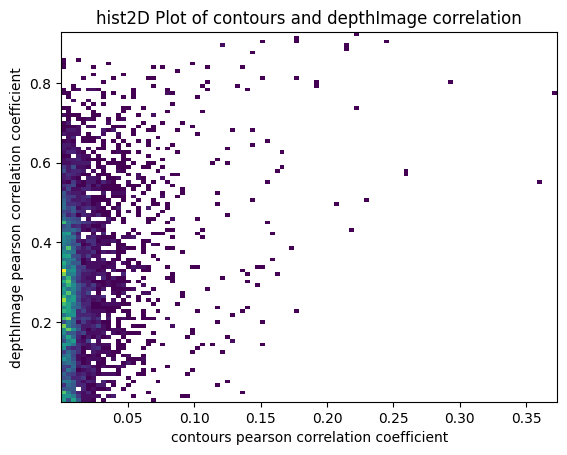

In [11]:
x = np.asarray(contours)
y = np.asarray(correlations)
plt.hist2d(x, y, bins=100,cmin = 1)
plt.xlabel('contours pearson correlation coefficient')
plt.ylabel('depthImage pearson correlation coefficient')
plt.title('hist2D Plot of contours and depthImage correlation')
plt.show()

In [130]:
random_pair = random.choice(random_combinations)
idx1,idx2 = random_pair[0],random_pair[1]
g1,g2,img1,img2,value,correlation = veifyContours(images[idx1],images[idx2])
plt.figure(figsize=(20,10))
plt.subplot(2, 4, 1)
plt.imshow(img1)
plt.subplot(2, 4, 2)
plt.imshow(img2)
plt.subplot(2, 4, 3)
plt.imshow(images[idx1])
plt.subplot(2, 4, 4)
plt.imshow(images[idx2])
plt.subplot(2, 4, 5)
plt.imshow(g1)
plt.subplot(2, 4, 6)
plt.imshow(g2)
print(value)
print(correlation)

2
1


TypeError: cannot unpack non-iterable NoneType object